### Packages ans utils

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from gaia.ml import SpatialModel

from sqlalchemy import create_engine
%matplotlib inline

### Load data

In [2]:
conn_params = {
    "host": "127.0.0.1",
    "port": 5432,
    "user": "focalai",
    "password": "ai",
    "database": "focalai"
}
uri = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(**conn_params)
print(uri)
engine = create_engine(uri)

postgresql+psycopg2://focalai:ai@127.0.0.1:5432/focalai


In [3]:
dvf_query = """
        SELECT * FROM dvf
        WHERE ST_DistanceSphere(geom, ST_GeomFromText('POINT({longitude} {latitude})', 4326))<1000000
        ORDER BY date_mutation DESC
        LIMIT 100000
        """.format(**{'longitude': 2.33, 'latitude': 48.86})
dvf_df = gpd.GeoDataFrame.from_postgis(dvf_query, engine)
dvf_df.head()

,date_mutation,id_mutation,valeur_fonciere,surface_totale,prix_m2,wkt,geom
0,2019-12-31,2019-293336,127500.0,29.75,4285.714286,POINT (-0.6090409999999999 44.829742),POINT (-0.60904 44.82974)
1,2019-12-31,2019-479143,52000.0,40.63,1279.842481,POINT (1.628959 47.777721),POINT (1.62896 47.77772)
2,2019-12-31,2019-476121,54900.0,26.16,2098.623853,POINT (1.920163 47.88928),POINT (1.92016 47.88928)
3,2019-12-31,2019-467250,120000.0,21.32,5628.517824,POINT (-2.512823 47.284386),POINT (-2.51282 47.28439)
4,2019-12-31,2019-467234,149057.0,32.42,4597.686613,POINT (-2.370374 47.279988),POINT (-2.37037 47.27999)


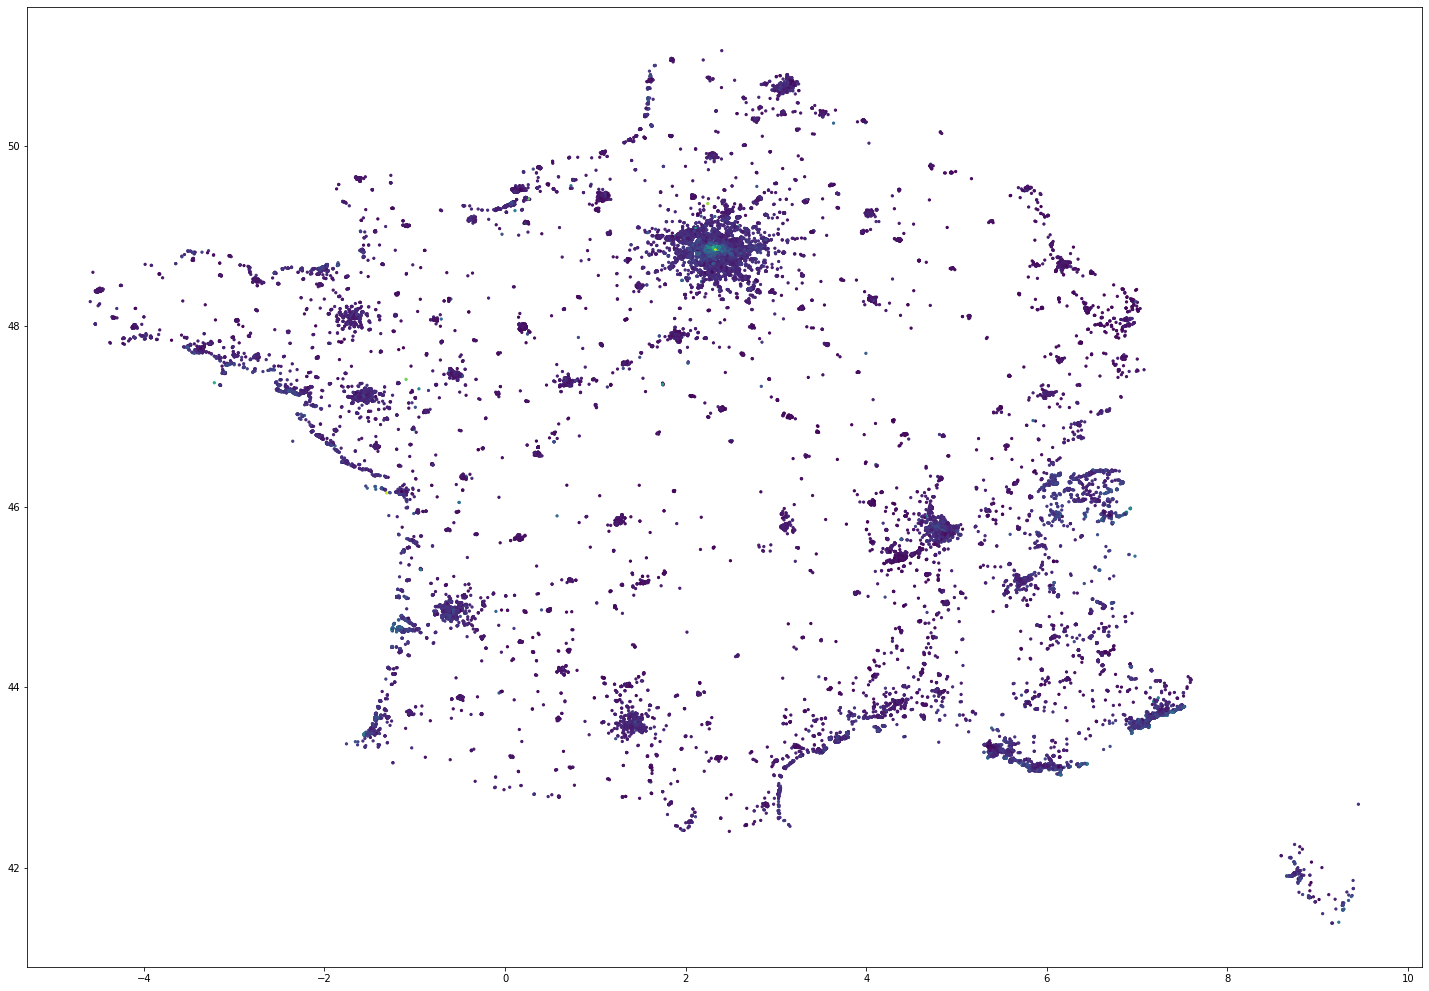

In [4]:
dvf_df.plot(figsize=(25, 25), column='prix_m2', s=5)

### SpatialModel

In [17]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
spatial_estimator = SpatialModel(
    cluster=KMeans(n_clusters=100, random_state=3105, n_init=50),
    estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=3105),
    pairwise_distance=rbf_kernel
    )

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dvf_df, test_size=0.33, random_state=3105)


Z_train = pd.DataFrame(zip(train['geom'].x.tolist(), train['geom'].y.tolist()))
X_train = pd.concat([train[['surface_totale']].reset_index(drop=True), Z_train], axis=1)
y_train = train['prix_m2']

Z_test = pd.DataFrame(zip(test['geom'].x.tolist(), test['geom'].y.tolist()))
X_test = pd.concat([test[['surface_totale']].reset_index(drop=True), Z_test], axis=1)
y_test = test['prix_m2']

In [ ]:
spatial_estimator.fit(X_train, Z_train, y_train)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=3105)
rf.fit(X_train, y_train)

In [9]:
y_pred_spat = spatial_estimator.predict(X_test, Z_test)
y_pred_norm = rf.predict(X_test)

In [10]:
errors = pd.DataFrame(zip(y_test, y_pred_spat, y_pred_norm))

In [13]:
errors.corr()

,0,1,2
0,1.000000,0.912562,0.910774
1,0.912562,1.000000,0.992626
2,0.910774,0.992626,1.000000


In [14]:
from sklearn.metrics import mean_absolute_error

In [15]:
mean_absolute_error(y_test, y_pred_spat)

751.1478033647802

In [16]:
mean_absolute_error(y_test, y_pred_norm)

762.0402949138254